# [Rolling Papers - Part 3](https://xpuzzlecorner.substack.com/p/rolling-papers-part-3)
## November 17, 2024

## Problem

_Imagine you have 6 square Magna tiles. These tiles have magnets on the side so that edges of shapes will stick together. Let’s assume for a moment that toss these six square tiles onto the ground and they will land in a random configuration such that they all six are connected edge-to-edge in one large piece. What’s the probability that this configuration will be foldable into a cube without rearranging the squares?_

## Solution

This problem requires a little bit of clarification, namely with how the overall shape is generated. Basically, is any valid 6-omino shape equally as likely as any other? In that case, the problem is fairly simple. 

Or we can conaisder the following:
You drop 1 tile at a time. After the firt tiles, the next tile is guaranteed to connect to the whole shape along a randomly selected boundary position. each unique boundary location where it's possible for a tile to connect to the shape is equally likely. So in the figure below, each of the 7 locations would be equally likely. 

![Illustration](figure1.png)

We should also note that for this problem, we should include the reflectional symmetries to be same shape since what we are concerned about is unfoldings, which should be either valid or invalid regardless of the orientation of the 6-omino.

With this in mind we proceed with the following steps for enumeration:

Start with a single square. This is the base case.
1. Add a square to the shape.
2. Canonicalize the shape by placing the lowest square at x=0 and leftmost square at y=0.
3. Generate each of symmetries of the shape and check if they are already in the list of shapes.
4. If this shape hasn't been encountered before, add it to the list of shapes with value 1. If it has been encountered, increment the value of that shape by 1 (since we will need to compute the probability eventually).
Continue until we have 6 squares in the shape.

In [39]:
import copy

class Square(object):
    def __init__(self, x: int, y: int) -> None:
        self._x = x
        self._y = y
    
    @property
    def x(self) -> int:
        return self._x

    @property
    def y(self) -> int:
        return self._y

    def __eq__(self, other: 'Square') -> bool:
        return self._x == other._x and self._y == other._y
    
    def __hash__(self) -> int:
        return hash((self._x, self._y))
    
    def __str__(self) -> str:
        return f'({self._x}, {self._y})'
    
    def __repr__(self) -> str:
        return self.__str__()

class Polyomino(object):

    def __init__(self) -> None:
        self.squares = set()
        self.boundary_locations = set()
        self.size = 0
        self.min_x = 0
        self.min_y = 0
    
    def canonical_form(self) -> set:
        canonicalized_squares = set()
        for s in self.squares:
            canonicalized_squares.add(Square(s.x - self.min_x, s.y - self.min_y))
        return canonicalized_squares
    
    def __hash__(self) -> int:
        return hash(frozenset(self.canonical_form()))
    
    def get_squares(self) -> set:
        return self.squares
    
    def get_boundary_locations(self) -> set:
        return self.boundary_locations

    def get_min_x(self) -> int:
        return self.min_x

    def get_min_y(self) -> int:
        return self.min_y
    
    def add_square(self, x, y) -> 'Polyomino':
        new_polyomino = copy.deepcopy(self)
        new_polyomino.squares.add(Square(x, y))
        new_polyomino.size += 1
        
        if x < new_polyomino.min_x:
            new_polyomino.min_x = x
        if y < new_polyomino.min_y:
            new_polyomino.min_y = y
        
        if Square(x, y) in new_polyomino.boundary_locations:
            new_polyomino.boundary_locations.remove(Square(x, y))
        
        # Add the new boundary locations
        if Square(x + 1, y) not in new_polyomino.squares:
            new_polyomino.boundary_locations.add(Square(x + 1, y))
        if Square(x - 1, y) not in new_polyomino.squares:
            new_polyomino.boundary_locations.add(Square(x - 1, y))
        if Square(x, y + 1) not in new_polyomino.squares:
            new_polyomino.boundary_locations.add(Square(x, y + 1))
        if Square(x, y - 1) not in new_polyomino.squares:
            new_polyomino.boundary_locations.add(Square(x, y - 1))
        
        return new_polyomino

    def copy_with_transform(self, transform: callable) -> 'Polyomino':
        new_polyomino = Polyomino()
        for s in self.squares:
            new_x, new_y = transform(s.x, s.y)
            new_polyomino = new_polyomino.add_square(new_x, new_y)
        
        return new_polyomino
    
    def reflect(self, axis_degree) -> 'Polyomino':
        assert axis_degree in [0, 45, 90, 135]

        if axis_degree == 0:
            transform = lambda x, y: (x, -y)
        elif axis_degree == 45:
            transform = lambda x, y: (y, x)
        elif axis_degree == 90:
            transform = lambda x, y: (-x, y)
        elif axis_degree == 135:
            transform = lambda x, y: (-y, -x)
        
        return self.copy_with_transform(transform)
   
    def rotate(self, degree) -> 'Polyomino':
        assert degree in [0, 90, 180, 270]

        if degree == 0:
            transform = lambda x, y: (x, y)
        elif degree == 90:
            transform = lambda x, y: (-y, x)
        elif degree == 180:
            transform = lambda x, y: (-x, -y)
        elif degree == 270:
            transform = lambda x, y: (y, -x)
        
        return self.copy_with_transform(transform)
    
    def __eq__(self, other: 'Polyomino') -> bool:
        return self.canonical_form() == other.canonical_form()
    
    def is_isometric(self, other: 'Polyomino') -> bool:
        reflections = [0, 45, 90, 135]
        rotations = [0, 90, 180, 270]
    
        for t in list(map(self.rotate, rotations)) + list(map(self.reflect, reflections)):
            if t == other:
                return True
        return False
    
    def __str__(self) -> str:
        return str(self.canonical_form())
    
    def __repr__(self) -> str:
        return self.__str__()

In [40]:
# Test case 1: Adding a square to a Polyomino
p = Polyomino()
p = p.add_square(0, 0)

p1 = p.add_square(1, 0)
assert p1.size == 2, "Test case 1 failed"
assert Square(1, 0) in p1.get_squares(), "Test case 1 failed"

# Test case 2: Reflecting a Polyomino
p2 = p.add_square(1, 0)
p2_reflected = p2.reflect(0)
assert p2_reflected.is_isometric(p2), "Test case 2 failed"

# Test case 3: Rotating a Polyomino
p3 = p.add_square(1, 0)
p3 = p3.add_square(1, 1)
p3_rotated = p3.rotate(90)
assert p3_rotated.is_isometric(p3), "Test case 3 failed"

# Test case 4: Checking isometric shapes
p4 = p.add_square(1, 0)
p4 = p4.add_square(0, 1)
p5 = p.add_square(0, 1)
p5 = p5.add_square(1, 0)
assert p4.is_isometric(p5), "Test case 4 failed"

# Test case 5: Checking non-isometric shapes
p6 = p.add_square(1, 0)
p6 = p6.add_square(1, 1)
p7 = p.add_square(1, 0)
p7 = p7.add_square(2, 0)
assert not p6.is_isometric(p7), "Test case 5 failed"

p8 = p.add_square(0, 1).add_square(1, 0)
p9 = p.add_square(1, 0).add_square(1, 1)
assert p8.is_isometric(p9), "Test case 6 failed"

print("All test cases passed!")

All test cases passed!


In [54]:
poly = Polyomino()
poly = poly.add_square(0, 0)
old_polys = {}
old_polys[poly] = 1

for _ in range(2, 7):
    new_polys = {}
    for p in list(old_polys.keys()):
        for b in p.get_boundary_locations():
            new_poly = p.add_square(b.x, b.y)
            found = False
            for existing_poly in new_polys.keys():
                if new_poly.is_isometric(existing_poly):
                    new_polys[existing_poly] += old_polys[p]
                    found = True
                    break
            if not found:
                new_polys[new_poly] = old_polys[p]
    old_polys = new_polys

print(new_polys)

{{(0, 1), (4, 0), (2, 1), (3, 1), (1, 1), (3, 0)}: 256, {(0, 1), (2, 1), (3, 1), (1, 1), (2, 0), (3, 0)}: 832, {(0, 1), (4, 0), (2, 1), (1, 1), (2, 0), (3, 0)}: 128, {(1, 2), (2, 1), (3, 1), (3, 0), (0, 2), (2, 2)}: 256, {(0, 1), (2, 1), (1, 1), (2, 0), (3, 0), (1, 0)}: 480, {(0, 1), (2, 1), (0, 0), (1, 1), (2, 0), (3, 0)}: 256, {(0, 1), (2, 1), (1, 1), (2, 0), (3, 0), (2, 2)}: 576, {(0, 1), (2, 1), (1, 1), (2, 0), (3, 0), (0, 2)}: 256, {(0, 1), (1, 2), (2, 1), (1, 1), (2, 0), (3, 0)}: 480, {(1, 2), (2, 1), (3, 1), (2, 0), (0, 2), (2, 2)}: 480, {(0, 1), (2, 1), (1, 1), (2, 0), (2, 2), (1, 0)}: 1152, {(0, 1), (2, 1), (3, 1), (1, 1), (2, 0), (1, 0)}: 576, {(1, 2), (2, 1), (1, 1), (2, 0), (0, 2), (2, 2)}: 480, {(0, 1), (2, 1), (0, 0), (1, 1), (2, 0), (1, 0)}: 416, {(0, 1), (1, 2), (2, 1), (1, 1), (2, 0), (1, 0)}: 768, {(0, 1), (2, 1), (1, 1), (2, 0), (0, 2), (1, 0)}: 832, {(1, 2), (2, 1), (1, 1), (2, 0), (3, 0), (0, 2)}: 128, {(0, 1), (1, 2), (1, 1), (2, 0), (2, 2), (1, 0)}: 288, {(0, 1),

In [66]:
print("Number of unique polyominoes of size 6: ", len(new_polys))

Number of unique polyominoes of size 6:  35


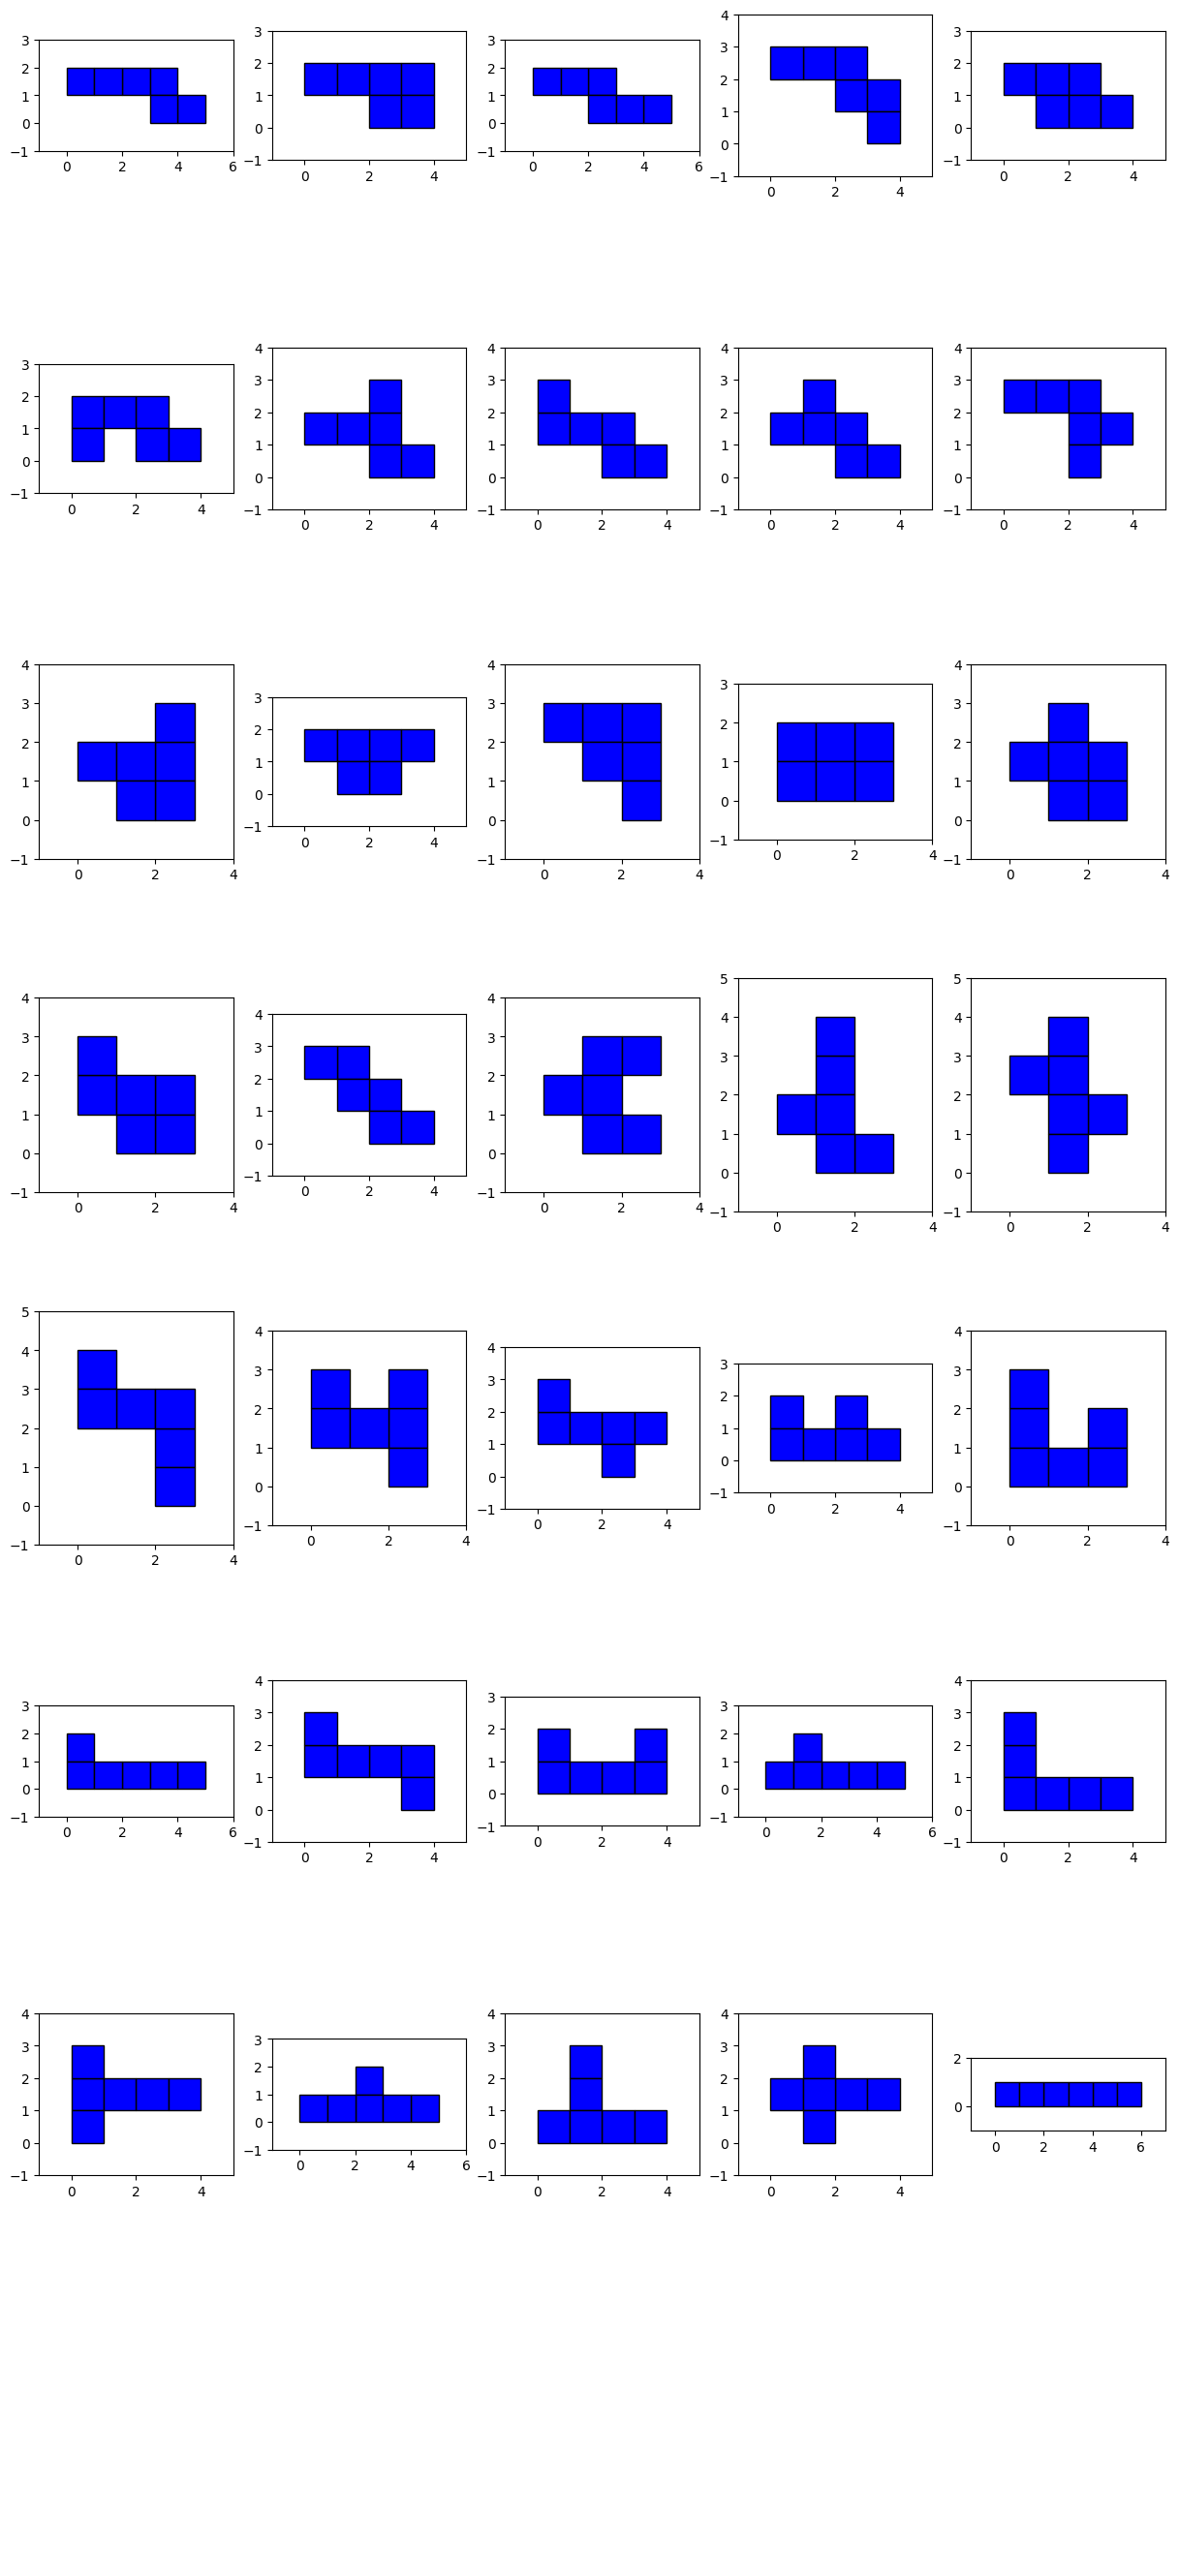

In [61]:
import matplotlib.pyplot as plt

def plot_polyomino(polyomino, ax):
    for square in polyomino.canonical_form():
        rect = plt.Rectangle((square.x, square.y), 1, 1, edgecolor='black', facecolor='blue')
        ax.add_patch(rect)
    ax.set_xlim(-1, max(s.x for s in polyomino.canonical_form()) + 2)
    ax.set_ylim(-1, max(s.y for s in polyomino.canonical_form()) + 2)
    ax.set_aspect('equal')

num_polys = len(new_polys)
fig, axs = plt.subplots((num_polys // 5) + 1, min(num_polys, 5), figsize=(15, (num_polys // 5) * 5))
axs = axs.flatten() if num_polys > 1 else [axs]

for ax, poly in zip(axs, new_polys.keys()):
    plot_polyomino(poly, ax)

# Hide any unused subplots
for ax in axs[len(new_polys):]:
    ax.axis('off')

plt.show()

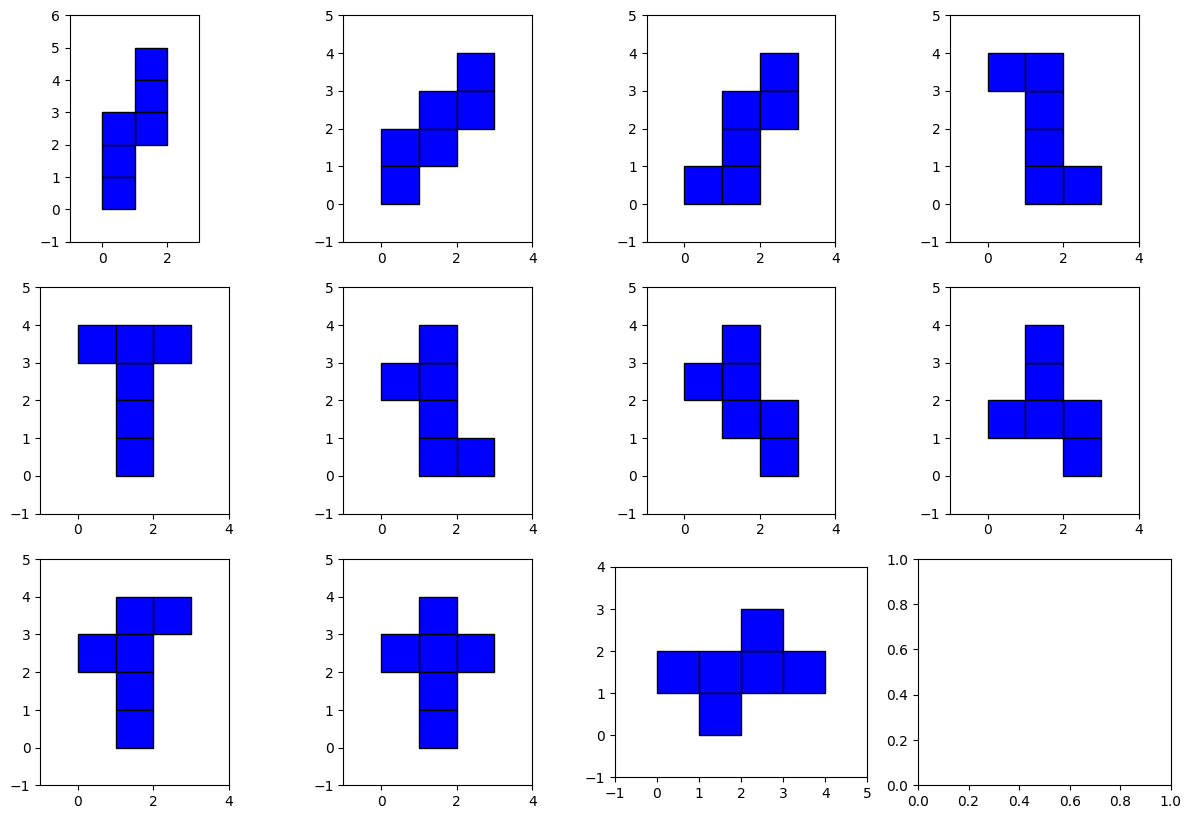

In [65]:
# Define the coordinates for each of the 11 distinct 6-polyominos that can be folded into a cube
cube_polyominoes_coords = [
    [(0, 0), (1, 0), (1, 1), (1, 2), (0, -1), (0, -2)],
    [(0, 0), (0, 1), (1, 1), (1, 2), (2, 2), (2, 3)],
    [(0, 0), (1, 0), (1, 1), (1, 2), (2, 2), (2, 3)],
    [(0, 0), (0, 1), (0, 2), (0, 3), (1, 0), (-1, 3)],
    [(0, 0), (0, 1), (0, 2), (0, 3), (-1, 3), (1, 3)],
    [(0, 0), (0, 1), (0, 2), (0, 3), (-1, 2), (1, 0)],
    [(0, 0), (1, 0), (1, 1), (1, -1), (2, -1), (2, -2)],
    [(0, 0), (1, 0), (1, 1), (1, 2), (2, 0), (2, -1)],
    [(0, 0), (0, 1), (0, 2), (0, 3), (1, 3), (-1, 2)],
    [(0, 0), (0, 1), (0, 2), (0, 3), (-1, 2), (1, 2)],
    [(0, 1), (1, 0), (1, 1), (2, 1), (2, 2), (3, 1)]
]

# Create Polyomino instances for each of the 11 distinct 6-polyominos
cube_polyominoes = []
for coords in cube_polyominoes_coords:
    poly = Polyomino()
    for x, y in coords:
        poly = poly.add_square(x, y)
    cube_polyominoes.append(poly)

# Plot the 11 distinct 6-polyominos
fig, axs = plt.subplots(3, 4, figsize=(15, 10))
axs = axs.flatten()
for ax, poly in zip(axs, cube_polyominoes):
    plot_polyomino(poly, ax)

In [69]:
cp_sum = 0
total = 0
for p in new_polys:
    if any(p.is_isometric(cp) for cp in cube_polyominoes):
        cp_sum += new_polys[p]
    total += new_polys[p]

print(f"{cp_sum}/{total} = {cp_sum/total}")

3968/14560 = 0.2725274725274725


In [76]:
import random

# To verify the result, let's simulate the process of generating random 6-polyominos and check the probability of generating a 6-polyomino that can be folded into a cube
num_trials = 10**3
num_cube_polyominos = 0
for _ in range(num_trials):
    poly = Polyomino()
    poly = poly.add_square(0, 0)
    for _ in range(5):
        s = random.sample(list(poly.get_boundary_locations()), 1)[0]
        poly = poly.add_square(s.x, s.y)
    if any(poly.is_isometric(cp) for cp in cube_polyominoes):
        num_cube_polyominos += 1

print(f"Simulated probability: {num_cube_polyominos/num_trials}")

Simulated probability: 0.272
